# Exploring the corruption network

## Packages and libraries

In [1]:
#sets the notebook width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
#Third Party Libraries
import pandas as pd
import numpy as np
from scipy import stats
import random
from operator import itemgetter
# Graphs
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as plticker
from matplotlib import ticker
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
#import powerlaw
import networkx as nx

In [4]:
def stdfigsize(scale=1, nx=1, ny=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.
    -------
    returns (7*ratio*scale*nx, 7.*scale*ny)
    By default: ratio=1.3
    If ratio<0 them ratio = golden ratio
    """
    if ratio < 0:
        ratio = 1.61803398875
    return((7*ratio*scale*nx, 7*scale*ny))

def stdrcparams(usetex=False):
    """
    Set several mpl.rcParams and sns.set_style for my taste.
    ----
    usetex = True
    ----
    """
    sns.set_style("white")
    sns.set_style({"xtick.direction": "in",
                 "ytick.direction": "in"})
    rcparams = {'text.usetex': usetex,
              'font.family': 'sans-serif',
              'font.sans-serif': ['Helvetica'],
              'text.latex.unicode': True,
              'text.latex.preamble': [r"\usepackage[T1]{fontenc}",
                                      r"\usepackage{lmodern}",
                                      r"\usepackage{amsmath}",
                                      r"\usepackage{mathptmx}"
                                      ],
              'axes.labelsize': 30,
              'axes.titlesize': 30,
              'ytick.right': 'on',
              'xtick.top': 'on',
              'xtick.labelsize': '25',
              'ytick.labelsize': '25',
              'axes.linewidth': 1.8,
              'xtick.major.width': 1.8,
              'xtick.minor.width': 1.8,
              'xtick.major.size': 14,
              'xtick.minor.size': 7,
              'xtick.major.pad': 10,
              'xtick.minor.pad': 10,
              'ytick.major.width': 1.8,
              'ytick.minor.width': 1.8,
              'ytick.major.size': 14,
              'ytick.minor.size': 7,
              'ytick.major.pad': 10,
              'ytick.minor.pad': 10,
              'axes.labelpad': 15,
              'axes.titlepad': 15,
              "xtick.direction": "in",
              "ytick.direction": "in"
              }
    mpl.rcParams.update(rcparams) 

stdrcparams(usetex=True)
figsize=stdfigsize()
print(figsize)

(9.1, 7)


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [5]:
def maplabels(df):
    names=list(df.i)
    [names.append(name) for name in list(df.j)]
    uniquenames=list(set(names))
    keys=uniquenames
    values=np.arange(len(uniquenames))+1
    
    
    names_dict=dict(np.transpose([keys,values]))
    reverse_dict=dict(np.transpose([values,keys]))
    
    myvalues = np.array(itemgetter(*list(df.i))(names_dict)).astype(int)
    df["ilabel"]=myvalues
    myvalues = np.array(itemgetter(*list(df.j))(names_dict)).astype(int)
    df["jlabel"]=myvalues
    df=df[["ilabel","jlabel","weight"]]
    return df,reverse_dict

def cdf(data, nbins=15, log=False, surv=True):
    """
    Estimates the survival distribution from a np.array.
    Parameters
    ----------
    data: np.array
    nbins: number of bins.
    log: True for log-spaced bins (Default: False).
    surv: False for cumulative distribution function (Default: True).
    ----------
    Returns [bins,pdf].
    """
    size = len(data)
    if log:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        bins = np.linspace(np.min(data), np.max(data),nbins)        
    densities = np.array([len(data[data>=binvalue])/size for binvalue in bins])
    if not surv:
        densities = 1 - densities
    return bins, densities

# Demography corruption network

- HV Ribeiro, LGA Alves, AF Martins, EK Lenzi, M Perc. The dynamical structure of political corruption networks. Journal of Complex Networks CNY002 1-15 (2018).

In [7]:
df_size=pd.read_csv("data/scandalssize.csv",index_col=0)

In [8]:
df_size.head()

,scandal,year,size
0,Caso Banespa,1987,4
1,Ferrovia Norte-Sul,1987,2
2,CPI da Corrupção,1988,3
3,Máfia da Previdência,1991,3
4,Caso Collor,1992,11


Text(0.5, 0, 'Scandals')

/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/lgaalves/miniconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


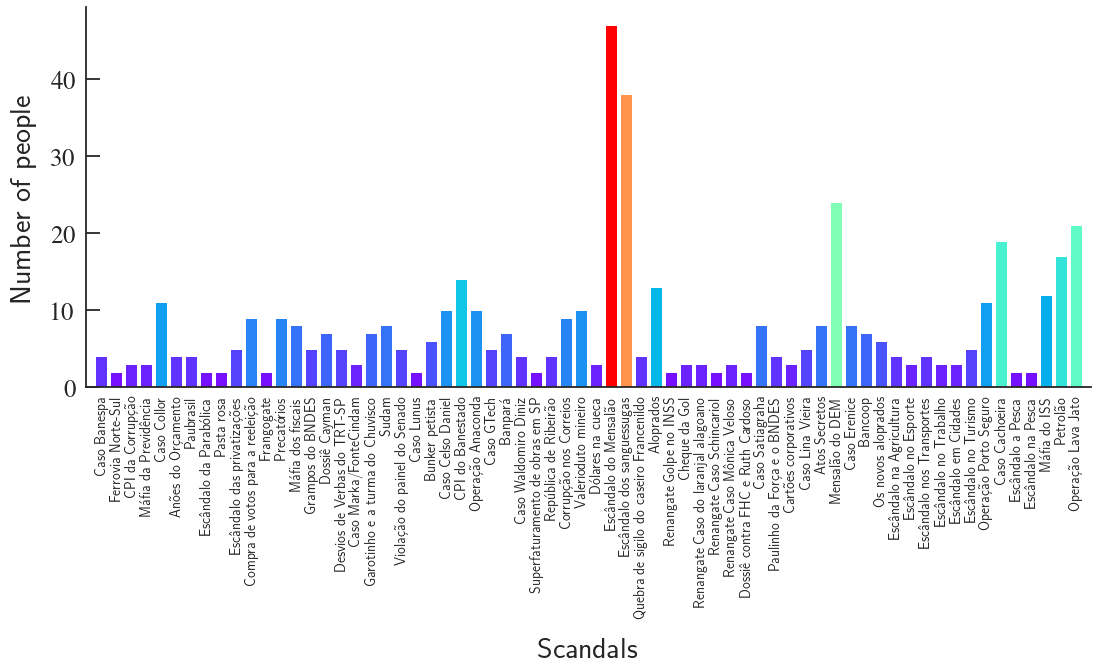

In [9]:
fig, ax = plt.subplots(figsize=(18,7))
y=df_size['size'].values.astype(int)
x=np.array(df_size.index)

norm = mpl.colors.Normalize(vmin=1, vmax=max(y))
cmap = plt.cm.rainbow
m = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cmaplist = [m.to_rgba(i) for i in y]
ax.bar(x,y,color=cmaplist)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.tick_params(axis='x',length=0)
#ax.tick_params(axis="x",length=0,direction="in", pad=-200)

ax.set_xlim(-1,66)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
labels=["",""]
labels.extend(list(df_size.scandal))
ax.set_xticklabels(labels,rotation=90,fontsize=14)
ax.set_ylabel(r"Number of people")
ax.set_xlabel(r"Scandals")

# Load data

In [10]:
df_net=pd.read_csv("data/edge_list.csv")[['Source','Target']]
df_net.head()

,Source,Target
0,246,243
1,246,60
2,246,240
3,246,242
4,246,241


# Corruption network 

In [11]:
G=nx.Graph()
G.add_edges_from(df_net.values)

In [12]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 404
Number of edges: 3549
Average degree:  17.5693


/Users/lgaalves/miniconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


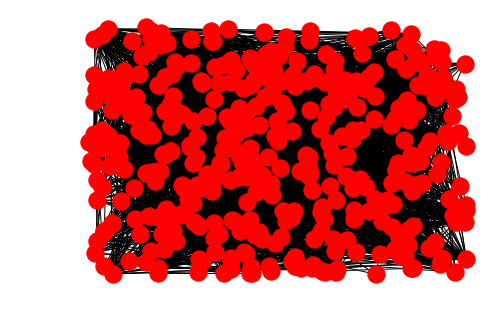

In [19]:
nx.draw(G,pos=nx.random_layout(G))

# Structural properties

In [13]:
np.average(list(dict(G.degree()).values()))

17.56930693069307

In [14]:
print('degree_assortativity_coefficient',nx.degree_assortativity_coefficient(G))
print('average_clustering',nx.average_clustering(G))

degree_assortativity_coefficient 0.5985375644805349
average_clustering 0.925765588813958


In [15]:
nx.global_efficiency(G)

0.2344131648187608

In [16]:
gcc=sorted(nx.connected_components(G),key=len,reverse=True)[0]

nx.average_shortest_path_length(nx.subgraph(G,gcc))

2.990018072542344

# Degree distribution 

In [20]:
degree_sequence = [d for n, d in G.degree()] # degree sequence

In [21]:
def moving_average(a, n=3):
    """
    Calculates the moving average over an array.
    Parameters
    ----------
    a: array   
    n: windows size (default = 3)
    ----------
    Returns the moving average of a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def pdf(data, nbins=15, log=False, symmetrical=False):
    """
    Estimates the pdf from a np.array.
    Parameters
    ----------
    data: np.array
    nbins: number of bins or np.histogram method name (Default: 15).
    log: True for log-spaced bins (Default: False).
    symmetrical: True for symmetrical bin interval (Default: False).
    ----------
    Returns [bins,pdf].
    """
    if not isinstance(nbins, str):
        if log:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.logspace(-maxdata, maxdata, nbins)
            else:
                bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
        else:
            if symmetrical:
                maxdata = max(np.abs(np.min(data)), np.abs(np.max(data)))
                bins = np.linspace(-maxdata, maxdata, nbins)
            else:
                bins = np.linspace(np.min(data), np.max(data), nbins)
    else:
        bins = nbins
    densities, bbins = np.histogram(data, bins=bins, density=True)
    return moving_average(bbins, 2), densities


def cdf(data, nbins=15, log=False, surv=True):
    """
    Estimates the survival distribution from a np.array.
    Parameters
    ----------
    data: np.array
    nbins: number of bins.
    log: True for log-spaced bins (Default: False).
    surv: False for cumulative distribution function (Default: True).
    ----------
    Returns [bins,pdf].
    """
    size = len(data)
    if log:
        bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), nbins)
    else:
        bins = np.linspace(np.min(data), np.max(data),nbins)        
    densities = np.array([len(data[data>=binvalue])/size for binvalue in bins])
    if not surv:
        densities = 1 - densities
    return bins, densities

Text(0.5, 0, 'Degree, $k$')

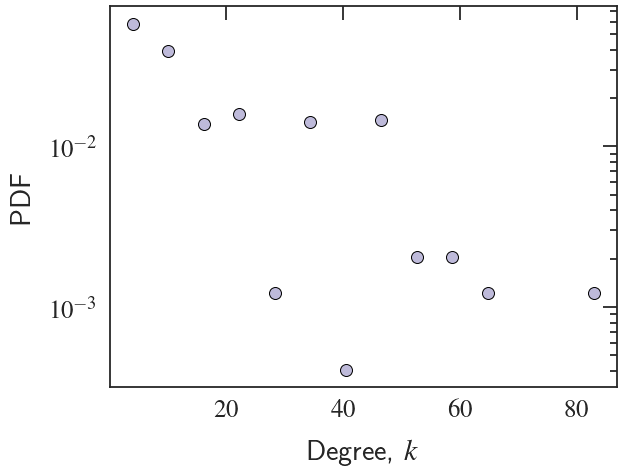

In [22]:
fig, ax = plt.subplots(figsize=figsize)
bins, densities=pdf(np.array(degree_sequence),log=False)
ax.plot(bins, densities,
        marker='o',
        color='#bebada',
        markeredgecolor='k',
        markersize=12,
        linewidth=0)


ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.set_yscale('log')
ax.set_ylabel(r"PDF")
ax.set_xlabel(r"Degree, $k$")

Text(0.5, 0, 'Degree, $k$')

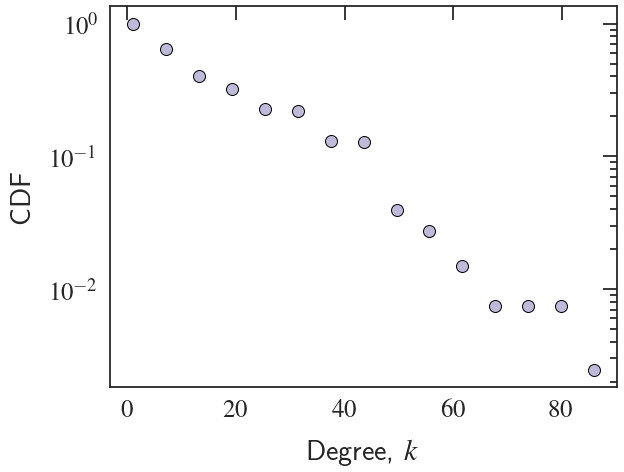

In [23]:
fig, ax = plt.subplots(figsize=figsize)
bins, densities=cdf(np.array(degree_sequence))
ax.plot(bins, densities,
        marker='o',
        color='#bebada',
        markeredgecolor='k',
        markersize=12,
        linewidth=0)



ax.xaxis.set_major_locator(ticker.MultipleLocator(20))

ax.set_yscale('log')
ax.set_ylabel(r"CDF")
ax.set_xlabel(r"Degree, $k$")

# Community structure and role of nodes (Netcarto)